In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
import random
from scipy.stats import pearsonr
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split,RepeatedStratifiedKFold,cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,BaggingClassifier,StackingClassifier
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
from sklearn.model_selection import RandomizedSearchCV
from matplotlib import pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.over_sampling import RandomOverSampler

In [2]:
transaction = pd.read_csv("transactions.csv")
customers = pd.read_csv("customers.csv")
geo = pd.read_csv("geo.csv")
test_result= pd.read_csv("pub_f6Xd8II.csv")
random.seed(2022)

In [3]:
customers[['REV_CURRENT_YEAR','REV_CURRENT_YEAR.2']]

,REV_CURRENT_YEAR,REV_CURRENT_YEAR.2
0,"""157832.813953488""",174585.011628
1,"""0""",872.093023
2,"""43377.9""",2097.670000
3,"""82989.85""",83251.950000
4,"""148.011627906977""",3601.232558
...,...,...
8447,"""24726.9230769231""",18550.102564
8448,"""0""",0.000000
8449,"""113394.74""",124405.640000
8450,"""0""",0.000000


In [4]:
def month_to_season(month):
    if month in [1, 2, 12]:
        return('winter')
    elif month in [3, 4, 5]:
        return('spring')
    elif month in [6, 7, 8]:
        return('summer')
    elif month in [9, 10, 11]:
        return('fall')

## Data Cleaning

In [5]:
# data cleansing
customers['CREATION_YEAR']=customers['CREATION_YEAR'].map(lambda year: int(str(year)[-4:]))
customers['REV_CURRENT_YEAR']=customers['REV_CURRENT_YEAR'].map(lambda rev: np.nan \
                if rev=='"Yes"' or rev=='"No"'else float(rev[1:-1])).astype('float')
mean_REV_CURRENT_YEAR= np.nanmean(customers['REV_CURRENT_YEAR'])
mean_REV_CURRENT_YEAR_1= np.nanmean(customers['REV_CURRENT_YEAR.1'])
mean_REV_CURRENT_YEAR_2= np.nanmean(customers['REV_CURRENT_YEAR.2'])

customers['COUNTRY']=customers['COUNTRY'].astype('string')


transaction['CUSTOMER'] = transaction['CUSTOMER'].\
                            map(lambda customer: 9000 if (customer =='"NA"' or customer=='"#NV"') \
                                                      else (-1 if customer=='"NA"' else int(customer[1:-1]))).astype('int')



train=pd.merge(transaction, geo, 
                   on='SALES_LOCATION', 
                   how='left')
train['COUNTRY']=train['COUNTRY'].map(lambda country: 'Switzerland' if country=='CH'else 'France').astype('string')
train=pd.merge(train, customers, 
                   on=['CUSTOMER','COUNTRY'], 
                   how='left')
train=train.drop(columns=['MO_ID', 'SO_ID'])
# product_names = ['COSTS_PRODUCT_A','COSTS_PRODUCT_B','COSTS_PRODUCT_C','COSTS_PRODUCT_D','COSTS_PRODUCT_E']
# train['COST_PRODUCT']=train[product_names].sum(axis=1)

# time
train['MO_CREATED_DATE']=pd.to_datetime(train['MO_CREATED_DATE'])
train['MONTH']=train['MO_CREATED_DATE'].map(lambda time: time.month)
train['SEASON']=train['MONTH'].map(month_to_season).astype('category')
train=train.drop(columns=['MONTH'])
train['YEAR']=train['MO_CREATED_DATE'].map(lambda time: time.year)
train['CREATION_YEAR']=np.nan_to_num(train['CREATION_YEAR'],nan=2007)
train=train.drop(columns=['MO_CREATED_DATE','SO_CREATED_DATE'])

#nan solving
train['REV_CURRENT_YEAR'].replace(0,mean_REV_CURRENT_YEAR)
train['REV_CURRENT_YEAR.1'].replace(0,mean_REV_CURRENT_YEAR_1)
train['REV_CURRENT_YEAR.2'].replace(0,mean_REV_CURRENT_YEAR_2)
train['OWNERSHIP'].fillna('No information')
train['REV_CURRENT_YEAR']=np.nan_to_num(train['REV_CURRENT_YEAR'],nan=mean_REV_CURRENT_YEAR)
train['REV_CURRENT_YEAR.1']=np.nan_to_num(train['REV_CURRENT_YEAR.1'],nan=mean_REV_CURRENT_YEAR_1)
train['REV_CURRENT_YEAR.2']=np.nan_to_num(train['REV_CURRENT_YEAR.2'],nan=mean_REV_CURRENT_YEAR_2)
train['ISIC']=np.nan_to_num(train['ISIC'],nan=np.nanmean(train['ISIC']))
train['REV_CURRENT_YEAR'].replace(0,mean_REV_CURRENT_YEAR)

#caterical
train['TECH']=train['TECH'].astype('category')
train['PRICE_LIST']=train['PRICE_LIST'].astype('category')
train['OFFER_TYPE']=train['OFFER_TYPE'].astype('category')
train['BUSINESS_TYPE']=train['BUSINESS_TYPE'].astype('category')
train['OWNERSHIP']=train['OWNERSHIP'].astype('category')
train['COUNTRY']=train['COUNTRY'].astype('category')
train['CURRENCY']=train['CURRENCY'].astype('category')
train["YEAR"]=train['YEAR'].astype('int')
train['CREATION_YEAR'].replace(np.nan, 'NaN', regex=True)
train['END_CUSTOMER']=train['END_CUSTOMER'].map(lambda a: 0 if a=='No' else 1 ).astype('category')

#new feature
train['AGE']=train['CREATION_YEAR']-train['YEAR']
train['TOTAL_COST']=train['SERVICE_COST']+train['MATERIAL_COST']
train['INTEREST_RATE']=train['OFFER_PRICE']/ train['TOTAL_COST']
train['INTEREST']=train['OFFER_PRICE'] - train['TOTAL_COST']
train['GROWTH']=train['REV_CURRENT_YEAR']-train['REV_CURRENT_YEAR.2']
train['GROWTH_RATE']=train['REV_CURRENT_YEAR']/train['REV_CURRENT_YEAR.2']
train['GROWTH_RATE']=np.nan_to_num(train['GROWTH_RATE'],nan=10)
train['GROWTH_RATE']=round(train['GROWTH_RATE'],4)
train.loc[train['GROWTH_RATE']>10, 'GROWTH_RATE'] = 10
train.loc[train['GROWTH_RATE']<-10, 'GROWTH_RATE'] = -10
train['TRANSITION_SIZE']=train['OFFER_PRICE'] / train['REV_CURRENT_YEAR']
train['TRANSITION_SIZE']=round(train['TRANSITION_SIZE'],4)
train.loc[train['TRANSITION_SIZE']>10, 'TRANSITION_SIZE'] = 10
train.loc[train['TRANSITION_SIZE']<-10, 'TRANSITION_SIZE'] = -10
train['COST_SIZE']=train['TOTAL_COST'] / train['REV_CURRENT_YEAR']
train['COST_SIZE']=round(train['COST_SIZE'],4)
train.loc[train['COST_SIZE']>10, 'COST_SIZE'] = 10
train.loc[train['COST_SIZE']<-10, 'COST_SIZE'] = -10
train['DISCOUNT']=train['SERVICE_LIST_PRICE']-train['SERVICE_COST']
train['DISCOUNT_RATE']=train['SERVICE_LIST_PRICE']/train['SERVICE_COST']
train['DISCOUNT_RATE']=np.nan_to_num(train['DISCOUNT_RATE'],nan=10)
train.loc[train['DISCOUNT_RATE']>10, 'DISCOUNT_RATE'] = 10
train['COST_STRUCTURE']=train['SERVICE_COST']/train['TOTAL_COST']
train['EXPECTED_INTEREST']=train['SERVICE_LIST_PRICE']-train['MATERIAL_COST']

#numeric
train[["TECH"]] =  OrdinalEncoder().fit_transform(train[["TECH"]])
train[["BUSINESS_TYPE"]] =  OrdinalEncoder().fit_transform(train[["BUSINESS_TYPE"]])
train[["SALES_LOCATION"]] =  OrdinalEncoder().fit_transform(train[["SALES_LOCATION"]])
train['SALES_LOCATION']=np.nan_to_num(train['SALES_LOCATION'],nan=44)
train[["PRICE_LIST"]] =  OrdinalEncoder().fit_transform(train[["PRICE_LIST"]])
train[["OWNERSHIP"]] =  OrdinalEncoder().fit_transform(train[["OWNERSHIP"]])
train['OWNERSHIP']=np.nan_to_num(train['OWNERSHIP'],nan=4)
train[["YEAR"]] =  OrdinalEncoder().fit_transform(train[["YEAR"]])
train[["SEASON"]] =  OrdinalEncoder().fit_transform(train[["SEASON"]])
train[["SALES_BRANCH"]] =  OrdinalEncoder().fit_transform(train[["SALES_BRANCH"]])
train['SALES_BRANCH']=np.nan_to_num(train['SALES_BRANCH'],nan=13)



#taking training set out 
test_set=train[train['OFFER_STATUS'].isna()]
train=train.drop(columns=['TEST_SET_ID'])
train.dropna(subset = ['OFFER_STATUS'], inplace=True)

train['OFFER_STATUS']=train['OFFER_STATUS'].map(lambda status: str(status).lower())
train['OFFER_STATUS']=train['OFFER_STATUS'].\
                        map(lambda status: 1 if (status=="won" or status =="win") else 0)\
                        .astype('int')



/Users/duc/opt/anaconda3/envs/ml/lib/python3.9/site-packages/pandas/core/series.py:2393: RuntimeWarning: overflow encountered in multiply
  result = self._values.round(decimals)


In [6]:
#normalize
# train['OFFER_PRICE']=(train['OFFER_PRICE']-train['OFFER_PRICE'].mean())/train['OFFER_PRICE'].std()
# train['MATERIAL_COST']=(train['MATERIAL_COST']-train['MATERIAL_COST'].mean())/train['MATERIAL_COST'].std()
# train['SERVICE_COST']=(train['SERVICE_COST']-train['SERVICE_COST'].mean())/train['SERVICE_COST'].std()
# # train['COST_PRODUCT']=(train['COST_PRODUCT']-train['COST_PRODUCT'].mean())/train['COST_PRODUCT'].std()
# train['ISIC']=(train['ISIC']-train['ISIC'].mean())/train['ISIC'].std()
#oversampling

# Create test_set

In [7]:
test_set['TEST_SET_ID'].astype('int')
test_transaction_result=pd.merge(test_result,test_set, how='left',left_on='id',right_on='TEST_SET_ID')
test_transaction_result

,id,prediction,CUSTOMER,END_CUSTOMER,OFFER_PRICE,SERVICE_LIST_PRICE,MATERIAL_COST,SERVICE_COST,PRICE_LIST,ISIC,...,INTEREST_RATE,INTEREST,GROWTH,GROWTH_RATE,TRANSITION_SIZE,COST_SIZE,DISCOUNT,DISCOUNT_RATE,COST_STRUCTURE,EXPECTED_INTEREST
0,6,NaN,6,1,23403.95,5932.00,4674.0,15186.39,2.0,6419.0,...,1.178423,3543.56,-218613.069767,0.7032,0.0452,0.0383,-9254.39,0.390613,0.764657,1258.00
1,9,NaN,9,1,52883.55,12075.00,7650.0,22680.97,1.0,8110.0,...,1.743550,22552.58,785194.341880,1.1871,0.0106,0.0061,-10605.97,0.532385,0.747783,4425.00
2,14,NaN,14,1,6704.00,3275.00,2706.0,2328.72,2.0,6419.0,...,1.331554,1669.28,291804.569767,1.4949,0.0076,0.0057,946.28,1.406352,0.462532,569.00
3,35,NaN,14,1,13704.00,7217.00,5721.0,3998.14,2.0,6419.0,...,1.410001,3984.86,291804.569767,1.4949,0.0155,0.0110,3218.86,1.805089,0.411368,1496.00
4,36,NaN,34,1,1976.95,1475.00,1230.0,11.28,2.0,4690.0,...,1.592670,735.67,-11500.060000,0.7069,0.0713,0.0448,1463.72,10.000000,0.009087,245.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2571,26019,NaN,888,1,12846.35,10691.00,7568.8,1680.57,3.0,2100.0,...,1.388889,3596.98,-32752.220930,0.3605,0.6958,0.5010,9010.43,6.361532,0.181696,3122.20
2572,26033,NaN,1358,1,8250.00,1880.00,1399.2,5161.30,3.0,4321.0,...,1.257526,1689.50,0.000000,10.0000,10.0000,10.0000,-3281.30,0.364249,0.786724,480.80
2573,26050,NaN,2210,1,4703.29,4460.14,2948.1,250.14,3.0,2100.0,...,1.470587,1505.05,-78662.210000,0.3593,0.1066,0.0725,4210.00,10.000000,0.078212,1512.04
2574,26058,NaN,1150,1,50896.50,31860.00,20800.2,13589.25,3.0,4321.0,...,1.480003,16507.05,9866.120000,1.2117,0.9013,0.6090,18270.75,2.344500,0.395158,11059.80


# Evaluate useful variable

In [8]:
def percent_success(factor:str):    
    success=train[train['OFFER_STATUS']==1][factor].value_counts()
    total=train[factor].value_counts()
    percent=success/total
    return percent

In [9]:
# # test variance between factors
# percent_success('TECH')# big variance
# percent_success('PRICE_LIST')# same for all values
# percent_success('OFFER_TYPE')# same for all values
# percent_success('BUSINESS_TYPE')# same for all values
# percent_success('OWNERSHIP')# same for all values
# percent_success('COUNTRY')# same for all values
# percent_success('CURRENCY')# same for all values
# percent_success('SEASON')# same for all values
# percent_success('SALES_LOCATION')# same for all values except Zürich EPS
# # percent_success('SEASON')# same for all values
# percent_success('SALES_BRANCH')
# percent_success('SALES_OFFICE')


In [10]:
# fig, axes = plt.subplots(1,3)
# fig.set_figwidth(25)
# fig.set_figheight(8)
# check_cols = ["OFFER_PRICE","SERVICE_COST","SERVICE_LIST_PRICE"]
# sns.set_style("dark")
# for i in range(len(check_cols)):
    
#     sns.kdeplot(data=train.loc[train["OFFER_STATUS"] == 1, check_cols[i]],
#                   ax=axes[i],
#                   label="WIN OFFER",
#                   color='blue',
#                   shade=True)

#     sns.kdeplot(data=train.loc[train["OFFER_STATUS"] == 0, check_cols[i]],
#                   ax=axes[i],
#                   label="FAIL OFFER",
#                   color='red',
#                   shade=True)

#     # plot vertical lines
#     axes[i].axvline(train.loc[train["OFFER_STATUS"] == 1, check_cols[i]].median(),
#                    color='blue')

#     axes[i].axvline(train.loc[train["OFFER_STATUS"] == 0, check_cols[i]].median(),
#                    color='red')
    
#     # plot annotations of values corresponding to the vertical lines
#     axes[i].annotate("Median {} Win Offer: {}".format(check_cols[i],
#                                                         train.loc[train["OFFER_STATUS"] == 1, check_cols[i]].median()),
#                                                         xy=(0.45, 0.95),
#                                                         xycoords='axes fraction',
#                                                         fontsize=15)
    
#     axes[i].annotate("Median {} Fail offer: {}".format(check_cols[i],
#                                                          train.loc[train["OFFER_STATUS"] == 0, check_cols[i]].median()),
#                                                          xy=(0.45, 0.90),
#                                                          xycoords='axes fraction',
#                                                          fontsize=15)
    
#     axes[i].title.set_text("{} and OFFER_STATUS".format(check_cols[i]))
#     axes[i].legend()
# plt.show()
# plt.close()

# Feature 

In [11]:
useful_features=['SERVICE_COST','TECH','BUSINESS_TYPE','SALES_LOCATION',\
                 'OFFER_PRICE','DISCOUNT','COST_SIZE','COST_STRUCTURE']

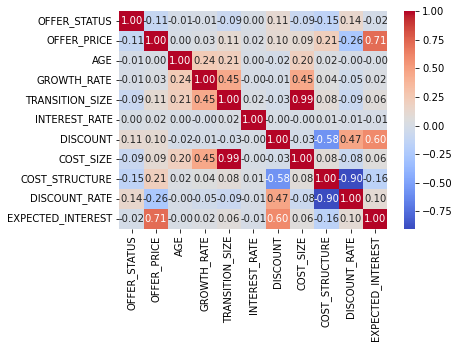

In [12]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["OFFER_STATUS","OFFER_PRICE",'AGE','GROWTH_RATE','TRANSITION_SIZE','INTEREST_RATE','DISCOUNT','COST_SIZE',
                'COST_STRUCTURE','DISCOUNT_RATE','EXPECTED_INTEREST']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

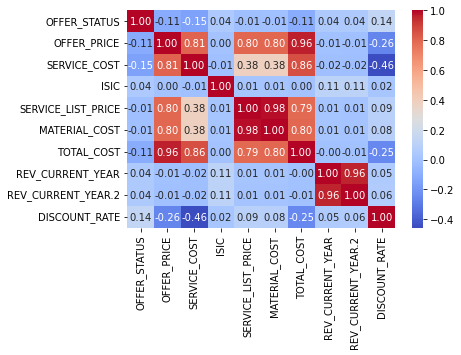

In [13]:
# Correlation matrix between numerical values (SibSp Parch Age and Fare values) and Survived 
g = sns.heatmap(train[["OFFER_STATUS",'OFFER_PRICE','SERVICE_COST','ISIC','SERVICE_LIST_PRICE','MATERIAL_COST',\
                 'TOTAL_COST','REV_CURRENT_YEAR','REV_CURRENT_YEAR.2','DISCOUNT_RATE']].corr(),annot=True, fmt = ".2f", cmap = "coolwarm")

# Training 

In [14]:
oversample = RandomOverSampler(sampling_strategy='minority')
X=train[useful_features]
y=train['OFFER_STATUS']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_over, y_over = X_train, y_train

In [15]:
# model = LogisticRegression(solver='liblinear', random_state=1).fit(X_train, y_train)
# # Step 4: Evaluate the model
# p_pred = model.predict_proba(X_train)
# y_pred = model.predict(X_train)
# score_ = model.score(X_train, y_train)
# conf_m = confusion_matrix(y_train, y_pred)
# report = classification_report(y_train, y_pred)
# sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
# spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
# print(f"sen={sen}")
# print(f"spec={spec}")
# print(f"BAC={(sen+spec)/2}")

In [16]:
# y_pred = model.predict(X_test)
# report = classification_report(y_test, y_pred)
# conf_m = confusion_matrix(y_test, y_pred)
# sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
# spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
# print(f"BAC={(sen+spec)/2}")

In [17]:
# clf = SVC()

# clf.fit(X_train, y_train)

# y_pred = clf.predict(X_train)

# conf_m = confusion_matrix(y_train, y_pred)
# report = classification_report(y_train, y_pred)
# sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
# spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
# print(f"sen={sen}")
# print(f"spec={spec}")
# print(f"BAC={(sen+spec)/2}")

# Random Forest

In [18]:
# random_forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_forest = RandomForestClassifier(max_samples=0.9,random_state=0,class_weight='balanced')
clf = RandomizedSearchCV(estimator=random_forest,param_distributions= random_grid,\
                         n_iter=50,cv=3,verbose=1,random_state=0)
clf.fit(X_over, y_over)
clf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 20,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 31,
 'bootstrap': True}

In [19]:
random_forest=RandomForestClassifier(bootstrap=True, max_depth=clf.best_params_['max_depth'],
                                     max_features=clf.best_params_['max_features'], 
                                     min_samples_leaf=clf.best_params_['min_samples_leaf'],
                                     min_samples_split=clf.best_params_['min_samples_split'],
                                     n_estimators=clf.best_params_['n_estimators'],
                                     class_weight='balanced',
                                     max_samples=0.9,random_state=0)
random_forest.fit(X_over, y_over)
y_pred = random_forest.predict(X_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f" sen={sen} , spec={spec}, BAC={(sen+spec)/2}")

 sen=0.9460470085470085 , spec=0.30246913580246915, BAC=0.6242580721747388


In [20]:
random_forest.feature_importances_

array([0.13635378, 0.05703133, 0.10187114, 0.10623751, 0.14950945,
       0.15483969, 0.14963678, 0.14452032])

# Balanced Random Forest

In [21]:
# balanced_random_forest
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 50, num = 40)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_forest = BalancedRandomForestClassifier(class_weight='balanced',max_samples=0.9,random_state=0)
clf = RandomizedSearchCV(estimator=random_forest,param_distributions= random_grid,\
                         n_iter=50,cv=3,verbose=1,random_state=0)
clf.fit(X_over, y_over)
clf.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'n_estimators': 18,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 18,
 'bootstrap': True}

In [22]:
balanced_random_forest=BalancedRandomForestClassifier(bootstrap=True, max_depth=clf.best_params_['max_depth'],
                                     max_features=clf.best_params_['max_features'], 
                                     min_samples_leaf=clf.best_params_['min_samples_leaf'],
                                     min_samples_split=clf.best_params_['min_samples_split'],
                                     n_estimators=clf.best_params_['n_estimators'],
                                     max_samples=0.9,
                                     class_weight='balanced',random_state=0)
balanced_random_forest.fit(X_over, y_over)
y_pred = balanced_random_forest.predict(X_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f" sen={sen} , spec={spec}, BAC={(sen+spec)/2}")

 sen=0.6111111111111112 , spec=0.6872427983539094, BAC=0.6491769547325104


In [23]:
balanced_random_forest.feature_importances_

array([0.13853878, 0.05134328, 0.07913176, 0.11207632, 0.15918776,
       0.16362448, 0.15112515, 0.14497248])

# Neural Network

In [24]:
nn=MLPClassifier(solver='lbfgs', alpha=1e-5,
            hidden_layer_sizes=(5, 2), random_state=1)
nn.fit(X_train,y_train)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')

In [38]:
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import Dense, Dropout
model = Sequential()
model.add(Input((input_nodes,)))
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.3, seed=0))
model.add(Dense(32, activation="relu"))
model.add(Dropout(0.3, seed=1))
model.add(Dense(16, activation="relu"))
model.add(Dropout(0.3, seed=2))
model.add(Dense(output_nodes))
model.compile(optimizer="adam", loss="mean_squared_logarithmic_error")
history = model.fit(
   X_train,
    y_train,
    batch_size=batch_size,
   epochs=100,
        validation_data=(X_valid, y_valid) if validate else None,
        verbose=2,
    )
y_pred = model.predict(X_test).argmax(1)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f" sen={sen} , spec={spec}, BAC={(sen+spec)/2}")

ModuleNotFoundError: No module named 'tensorflow'

In [26]:
# gradient_bc.feature_importances_

In [27]:
# Decistion Tree
decision_tree = DecisionTreeClassifier(class_weight='balanced')
decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f" sen={sen} , spec={spec}, BAC={(sen+spec)/2}")

 sen=0.8493589743589743 , spec=0.37448559670781895, BAC=0.6119222855333967


In [28]:
# # Bagging _classifier
# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 1, stop = 20, num = 20)]
# # Maximum number of levels in tree
# max_depth = [int(x) for x in np.linspace(10, 60, num = 60)]
# max_depth.append(None)
# # Minimum number of samples required to split a node
# min_samples_split = [2, 5, 10]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [1, 2, 4]
# # Method of selecting samples for training each tree
# bootstrap = [True]
# # Create the random grid
# random_grid = {'n_estimators': n_estimators,
#                'max_features': sp_randFloat(),
#                'bootstrap': bootstrap}
# bagging_classifier = BaggingClassifier(max_samples=0.9,random_state=0)
# clf = RandomizedSearchCV(estimator=bagging_classifier,param_distributions= random_grid,\
#                          n_iter=100,cv=3,verbose=1,random_state=0)
# clf.fit(X_over, y_over)
# clf.best_params_

In [29]:
#Bagging Classifier
bagging_classifier = BaggingClassifier(random_state=0)
bagging_classifier.fit(X_over, y_over)
y_pred = bagging_classifier.predict(X_test)
conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f" sen={sen} , spec={spec}, BAC={(sen+spec)/2}")

 sen=0.9081196581196581 , spec=0.360082304526749, BAC=0.6341009813232036


In [30]:
# max_value=(0,1,0)
# for k in range(25,45):
#     reg2 = RandomForestRegressor(random_state=0,max_depth=k,bootstrap=True,max_samples=0.9)
#     reg2.fit(X_train, y_train)
#     y_pred=reg2.predict(X_test)
#     y_pred=np.around(y_pred)
#     conf_m = confusion_matrix(y_test, y_pred)
#     report = classification_report(y_test, y_pred)
#     sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
#     spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
#     print(f"k={k} iterations: sen={sen} , spec={spec}, BAC={(sen+spec)/2}")
#     if (max_value[2]<(sen+spec)/2):
#         max_value=(k,1,(sen+spec)/2)
# for i in range(1,4):
#     reg2 = RandomForestRegressor(random_state=0,max_depth=max_value[0],bootstrap=True,max_samples=0.9,min_samples_leaf=i)
#     reg2.fit(X_train, y_train)
#     y_pred=reg2.predict(X_test)
#     y_pred=np.around(y_pred)
#     conf_m = confusion_matrix(y_test, y_pred)
#     report = classification_report(y_test, y_pred)
#     sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
#     spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
#     print(f"i={i} iterations: sen={sen} , spec={spec}, BAC={(sen+spec)/2}")
#     if (max_value[2]<(sen+spec)/2):
#         max_value=(max_value[0],i,(sen+spec)/2)
# print(max_value)

In [31]:
# y_pred=reg2.predict(X_test)
# y_pred=np.around(y_pred)
# conf_m = confusion_matrix(y_test, y_pred)
# report = classification_report(y_test, y_pred)
# sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
# spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
# print(f"sen={sen}")
# print(f"spec={spec}")
# print(f"BAC={(sen+spec)/2}")

In [32]:
voting_classifier = VotingClassifier(estimators=[
        ('rf', random_forest),('bl',balanced_random_forest),\
        ('bc',bagging_classifier),("dt",decision_tree)],\
                                     weights=[1/3,1/3,1/3,0] ,voting='soft')
voting_classifier = voting_classifier.fit(X_over, y_over)
y_pred=voting_classifier.predict(X_test)

conf_m = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f" sen={sen} , spec={spec}, BAC={(sen+spec)/2}")

 sen=0.8194444444444444 , spec=0.5349794238683128, BAC=0.6772119341563786


In [33]:
conf_m

array([[ 260,  226],
       [ 338, 1534]])

In [34]:
voting_classifier = voting_classifier.fit(X, y)
y_pred=voting_classifier.predict(X)
conf_m = confusion_matrix(y, y_pred)
report = classification_report(y, y_pred)
sen=conf_m[1][1]/(conf_m[1][0]+conf_m[1][1])
spec=conf_m[0][0]/(conf_m[0][1]+conf_m[0][0])
print(f"BAC={(sen+spec)/2}")

BAC=0.9745129451146772


In [35]:
X_t=test_transaction_result[useful_features]
y_result=voting_classifier.predict(X_t)
test_result['prediction']=y_result

In [36]:
test_result['prediction']=test_result['prediction'].astype('int')
test_result

,id,prediction
0,6,0
1,9,0
2,14,1
3,35,0
4,36,0
...,...,...
2571,26019,1
2572,26033,0
2573,26050,1
2574,26058,1


In [37]:
test_result.to_csv('prediction_SuperFreakonomics.csv',index=False)